<a href="https://colab.research.google.com/github/AiJared/job_matching_model/blob/main/job_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [16]:
# First, mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [17]:
# Load actual data (uncomment and modify for your actual data)

# Load your actual data
candidates_df = pd.read_csv('D:/Projects/DJ/job_matching/website/job_matching/ai/candidates.csv')
jobs_df = pd.read_csv('D:/Projects/DJ/job_matching/website/job_matching/ai/jobs.csv')
matches_df = pd.read_csv('D:/Projects/DJ/job_matching/website/job_matching/ai/matches.csv')

# Display basic statistics
print("Candidates DataFrame Info:")
print(candidates_df.info())
print("\nJobs DataFrame Info:")
print(jobs_df.info())
print("\nMatches DataFrame Info:")
print(matches_df.info())

Candidates DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1500 non-null   int64 
 1   skills        1500 non-null   object
 2   experience    1500 non-null   int64 
 3   education     1500 non-null   object
 4   location      1500 non-null   object
 5   career_field  1500 non-null   object
 6   relocation    1500 non-null   bool  
dtypes: bool(1), int64(2), object(4)
memory usage: 71.9+ KB
None

Jobs DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  1000 non-null   int64 
 1   title               1000 non-null   object
 2   required_skills     1000 non-null   object
 3   min_experience      1000 non-null   int64 
 4   requ

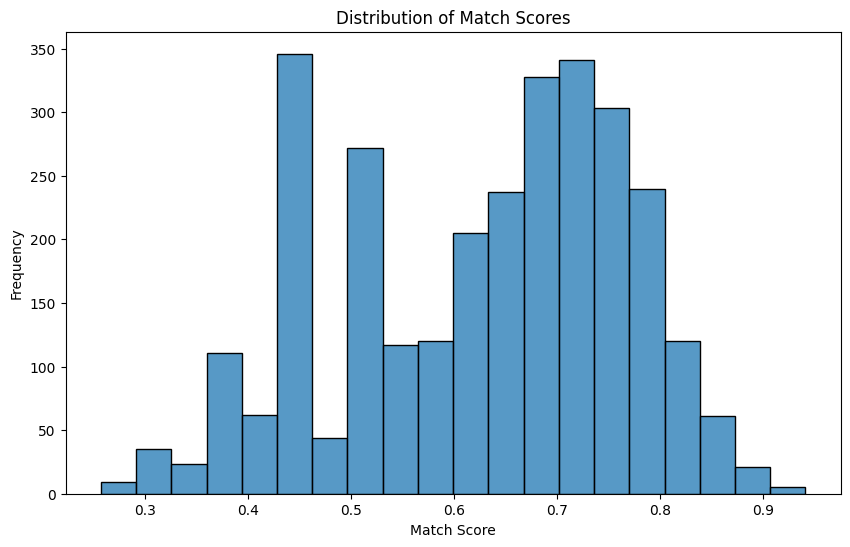

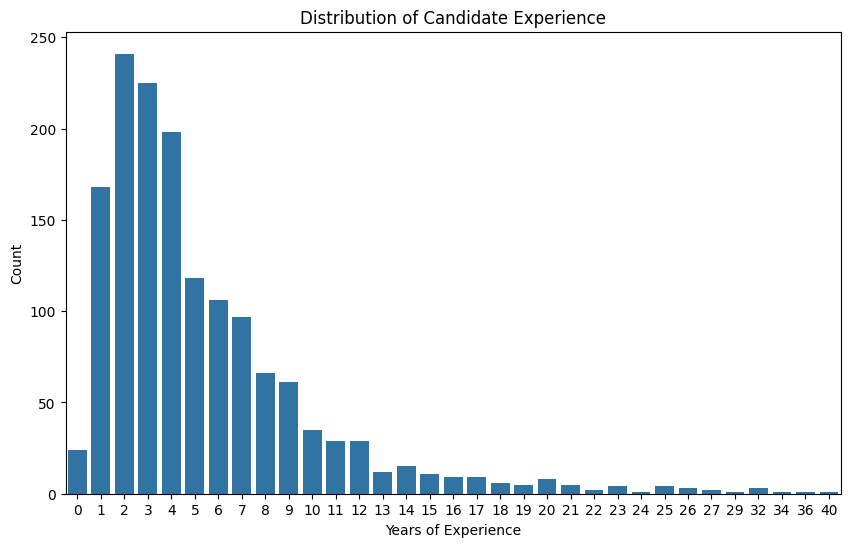

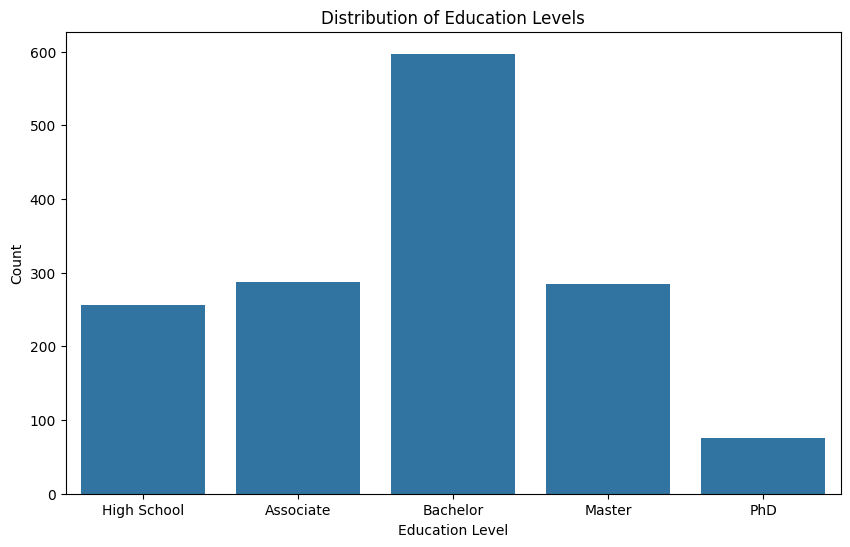

In [18]:
# Data Exploration and Visualization
# Explore the distribution of match scores
plt.figure(figsize=(10, 6))
sns.histplot(matches_df['match_score'], bins=20)
plt.title('Distribution of Match Scores')
plt.xlabel('Match Score')
plt.ylabel('Frequency')
plt.show()

# Explore candidate experience distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='experience', data=candidates_df)
plt.title('Distribution of Candidate Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Count')
plt.show()

# Explore education distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='education', data=candidates_df)
plt.title('Distribution of Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.show()

In [19]:
# Feature Engineering - Creating Preprocessing Pipelines

# Create preprocessing pipelines for candidates
def create_candidate_preprocessor(candidates_df):
    # Define different transformers for different types of features

    # Text features - convert skills to TF-IDF vectors
    text_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=100, stop_words='english'))
    ])

    # Categorical features - one-hot encode education and location
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Numeric features - scale experience
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])

    # Combine transformers using ColumnTransformer
    candidate_preprocessor = ColumnTransformer(
        transformers=[
            ('text', text_transformer, 'skills'),
            ('cat', categorical_transformer, ['education', 'location']),
            ('num', numeric_transformer, ['experience'])
        ],
        remainder='drop'  # Drop other columns not specified
    )

    # Fit the preprocessor on candidates data
    candidate_preprocessor.fit(candidates_df)

    return candidate_preprocessor

# Create preprocessing pipelines for jobs
def create_job_preprocessor(jobs_df):
    # Define different transformers for different types of features

    # Text features - convert required skills and title to TF-IDF vectors
    text_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=100, stop_words='english'))
    ])

    # Text features for job title
    title_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=50, stop_words='english'))
    ])

    # Categorical features - one-hot encode education and location
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Numeric features - scale minimum experience
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])

    # Combine transformers using ColumnTransformer
    job_preprocessor = ColumnTransformer(
        transformers=[
            ('skills_text', text_transformer, 'required_skills'),
            ('title_text', title_transformer, 'title'),
            ('cat', categorical_transformer, ['required_education', 'location']),
            ('num', numeric_transformer, ['min_experience'])
        ],
        remainder='drop'  # Drop other columns not specified
    )

    # Fit the preprocessor on jobs data
    job_preprocessor.fit(jobs_df)

    return job_preprocessor

# Create and fit preprocessors
candidate_preprocessor = create_candidate_preprocessor(candidates_df)
job_preprocessor = create_job_preprocessor(jobs_df)

In [20]:
# Transform the data using preprocessors

# Transform candidate data
candidate_features = candidate_preprocessor.transform(candidates_df)
print(f"Candidate features shape: {candidate_features.shape}")

# Transform job data
job_features = job_preprocessor.transform(jobs_df)
print(f"Job features shape: {job_features.shape}")

Candidate features shape: (1500, 142)
Job features shape: (1000, 192)


In [21]:
# Prepare training data

def prepare_training_data(matches_df, candidates_df, jobs_df, candidate_features, job_features):
    # Create indices for faster lookups
    candidate_indices = {candidate_id: idx for idx, candidate_id in enumerate(candidates_df['id'])}
    job_indices = {job_id: idx for idx, job_id in enumerate(jobs_df['id'])}

    # Create training pairs and scores
    train_pairs = []
    match_scores = []

    for _, row in matches_df.iterrows():
        if row['candidate_id'] in candidate_indices and row['job_id'] in job_indices:
            candidate_idx = candidate_indices[row['candidate_id']]
            job_idx = job_indices[row['job_id']]

            train_pairs.append((candidate_idx, job_idx))
            match_scores.append(row['match_score'])

    # Convert to numpy arrays
    train_pairs = np.array(train_pairs)
    match_scores = np.array(match_scores)

    # Split into training and validation sets
    train_indices, val_indices = train_test_split(
        np.arange(len(train_pairs)),
        test_size=0.2,
        random_state=42
    )

    return train_pairs, match_scores, train_indices, val_indices

# Prepare training data
train_pairs, match_scores, train_indices, val_indices = prepare_training_data(
    matches_df, candidates_df, jobs_df, candidate_features, job_features
)

print(f"Number of training pairs: {len(train_indices)}")
print(f"Number of validation pairs: {len(val_indices)}")

Number of training pairs: 2400
Number of validation pairs: 600


In [22]:
# Clear all previously registered custom objects
keras.saving.get_custom_objects().clear()

# Custom L2 Normalization Layer
@keras.saving.register_keras_serializable()
class L2Normalize(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2Normalize, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=1)

    def get_config(self):
        config = super(L2Normalize, self).get_config()
        return config

# Dual Encoder Architecture
def create_embedding_model(input_dim, name=None):
    """Create encoder model that converts features to embeddings"""
    inputs = tf.keras.layers.Input(shape=(input_dim,))
    
    x = tf.keras.layers.Dense(256, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    embedding = tf.keras.layers.Dense(128)(x)

    return tf.keras.Model(inputs=inputs, outputs=embedding, name=name)

def create_matching_model(candidate_input_dim, job_input_dim):
    """Create the complete matching model with L2-normalized dual encoders"""

    # Encoders
    candidate_encoder = create_embedding_model(candidate_input_dim, "candidate_encoder")
    job_encoder = create_embedding_model(job_input_dim, "job_encoder")

    # Inputs
    candidate_input = tf.keras.layers.Input(shape=(candidate_input_dim,), name="candidate_input")
    job_input = tf.keras.layers.Input(shape=(job_input_dim,), name="job_input")

    # Embeddings
    candidate_embedding = candidate_encoder(candidate_input)
    job_embedding = job_encoder(job_input)

    # Replace Lambda with L2Normalize
    normalized_candidate = L2Normalize()(candidate_embedding)
    normalized_job = L2Normalize()(job_embedding)

    # Cosine similarity via dot product
    similarity = tf.keras.layers.Dot(axes=1)([normalized_candidate, normalized_job])

    # Sigmoid scaling
    match_score = tf.keras.layers.Dense(1, activation='sigmoid')(similarity)

    # Full model
    model = tf.keras.Model(
        inputs=[candidate_input, job_input],
        outputs=match_score,
        name="matching_model"
    )

    # Encoder-only models for inference
    candidate_model = tf.keras.Model(candidate_input, normalized_candidate, name="candidate_inference")
    job_model = tf.keras.Model(job_input, normalized_job, name="job_inference")

    return model, candidate_model, job_model

# Instantiate models
matching_model, candidate_model, job_model = create_matching_model(
    candidate_input_dim=candidate_features.shape[1],
    job_input_dim=job_features.shape[1]
)

# Summaries
print("Matching Model Summary:")
matching_model.summary()

print("\nCandidate Model Summary:")
candidate_model.summary()

print("\nJob Model Summary:")
job_model.summary()


Matching Model Summary:


Model: "matching_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ candidate_input     │ (None, 142)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_input           │ (None, 192)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ candidate_encoder   │ (None, 128)       │     86,016 │ candidate_input[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ job_encoder         │ (None, 128)       │     98,816 │ job_input[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l2_normalize_2      │ (None, 128)       │          0 │ candidate_encode… │
│ (L2Normalize)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l2_normalize_3      │ (None, 128)       │          0 │ job_encoder[0][0] │
│ (L2Normalize)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1)         │          0 │ l2_normalize_2[0… │
│                     │                   │            │ l2_normalize_3[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │          2 │ dot_1[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 184,834 (722.01 KB)

 Trainable params: 184,834 (722.01 KB)

 Non-trainable params: 0 (0.00 B)


Candidate Model Summary:


Model: "candidate_inference"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ candidate_input (InputLayer)    │ (None, 142)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ candidate_encoder (Functional)  │ (None, 128)            │        86,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_normalize_2 (L2Normalize)    │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,016 (336.00 KB)

 Trainable params: 86,016 (336.00 KB)

 Non-trainable params: 0 (0.00 B)


Job Model Summary:


Model: "job_inference"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ job_input (InputLayer)          │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ job_encoder (Functional)        │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_normalize_3 (L2Normalize)    │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,816 (386.00 KB)

 Trainable params: 98,816 (386.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the model

# Compile the matching model
matching_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

# Create training and validation data
X_train = [
    candidate_features[train_pairs[train_indices, 0]].toarray(),
    job_features[train_pairs[train_indices, 1]].toarray()
]
y_train = match_scores[train_indices]

X_val = [
    candidate_features[train_pairs[val_indices, 0]].toarray(),
    job_features[train_pairs[val_indices, 1]].toarray()
]
y_val = match_scores[val_indices]

# Train the model
history = matching_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0269 - mae: 0.1435 - val_loss: 0.0204 - val_mae: 0.1247
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0210 - mae: 0.1274 - val_loss: 0.0186 - val_mae: 0.1188
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0196 - mae: 0.1226 - val_loss: 0.0177 - val_mae: 0.1154
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0189 - mae: 0.1210 - val_loss: 0.0167 - val_mae: 0.1131
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0173 - mae: 0.1152 - val_loss: 0.0165 - val_mae: 0.1119
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0153 - mae: 0.1071 - val_loss: 0.0166 - val_mae: 0.1112
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0141 - mae: 0.1013 - val_loss: 0.0171 - val_mae: 0.1124
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0124 - mae: 0.0942 - val_loss: 0.0168 - val_mae: 0.1094


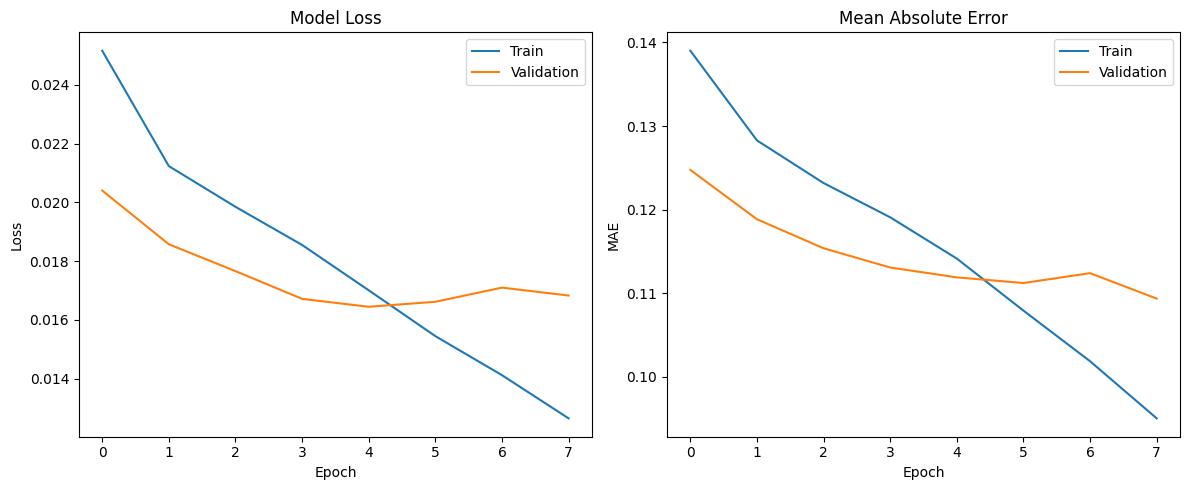

In [24]:
# Visualize training results

# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [25]:
# Evaluate the model on some examples

def predict_match_score(candidate_idx, job_idx):
    """Predict match score between a candidate and job"""
    # Get feature vectors
    candidate_vector = candidate_features[candidate_idx].toarray().reshape(1, -1)
    job_vector = job_features[job_idx].toarray().reshape(1, -1)

    # Predict match score
    score = matching_model.predict([candidate_vector, job_vector])[0][0]

    return score

# Select a few examples to test
test_examples = [
    (0, 0),  # First candidate, first job
    (0, 1),  # First candidate, second job
    (1, 0),  # Second candidate, first job
    (1, 1)   # Second candidate, second job
]

print("Example match predictions:")
for candidate_idx, job_idx in test_examples:
    score = predict_match_score(candidate_idx, job_idx)
    print(f"Candidate {candidates_df.iloc[candidate_idx]['id']} - "
          f"Job {jobs_df.iloc[job_idx]['id']}: "
          f"Score = {score:.4f}")

Example match predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Candidate 1 - Job 1: Score = 0.5449
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Candidate 1 - Job 2: Score = 0.4667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Candidate 2 - Job 1: Score = 0.5724
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Candidate 2 - Job 2: Score = 0.4775


In [26]:
# Find top matching jobs for a candidate

def find_top_matching_jobs(candidate_idx, top_n=5):
    """Find the top N matching jobs for a candidate"""
    # Get candidate embedding
    candidate_vector = candidate_features[candidate_idx].toarray().reshape(1, -1)
    candidate_embedding = candidate_model.predict(candidate_vector)

    # Compute similarity with all jobs
    all_job_vectors = job_features.toarray()
    all_job_embeddings = job_model.predict(all_job_vectors)

    # Calculate cosine similarity (dot product of normalized vectors)
    similarities = np.dot(candidate_embedding, all_job_embeddings.T)[0]

    # Get top N job indices
    top_job_indices = np.argsort(similarities)[::-1][:top_n]

    # Return job information with scores
    results = []
    for job_idx in top_job_indices:
        job = jobs_df.iloc[job_idx]
        score = similarities[job_idx]

        results.append({
            'job_id': job['id'],
            'title': job['title'],
            'required_skills': job['required_skills'],
            'match_score': float(score)
        })

    return results

# Test for a specific candidate
candidate_idx = 3  # Fourth candidate
top_jobs = find_top_matching_jobs(candidate_idx, top_n=5)

print(f"Top matching jobs for Candidate {candidates_df.iloc[candidate_idx]['id']}:")
print(f"Skills: {candidates_df.iloc[candidate_idx]['skills']}")
print(f"Experience: {candidates_df.iloc[candidate_idx]['experience']} years")
print(f"Education: {candidates_df.iloc[candidate_idx]['education']}")
print("\nTop 5 matching jobs:")
for i, job in enumerate(top_jobs, 1):
    print(f"{i}. {job['title']} (ID: {job['job_id']}) - Score: {job['match_score']:.4f}")
    print(f"   Required skills: {job['required_skills']}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Top matching jobs for Candidate 4:
Skills: differentiated instruction instructional design lesson planning stem education blackboard canvas student support
Experience: 8 years
Education: Bachelor

Top 5 matching jobs:
1. ESL Teacher (ID: 931) - Score: 0.9277
   Required skills: student assessment google classroom student engagement special education educational psychology educational administration

2. HR Business Partner (ID: 945) - Score: 0.9267
   Required skills: workforce planning benefits administration employee retention bamboo hr diversity & inclusion

3. Superintendent (ID: 669) - Score: 0.9242
   Required skills: iep development curriculum development instructional design lms educational technology educational leadership

4. Financial Advisor (ID: 294) - Score: 0.9241
   Required skills: cfa gaap risk assessment

5. Employee Relations Manager (ID: 647) - Score: 0.9236
   Required skills: hr analytic

In [27]:
# Define the final save directory
SAVE_DIR = 'D:/Projects/DJ/job_matching/website/job_matching/ai_models'
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the models in .keras format (recommended for TF2+)
matching_model.save(os.path.join(SAVE_DIR, 'matching_model.keras'))
candidate_model.save(os.path.join(SAVE_DIR, 'candidate_model.keras'))
job_model.save(os.path.join(SAVE_DIR, 'job_model.keras'))

# Save the preprocessors as .pkl
with open(os.path.join(SAVE_DIR, 'candidate_preprocessor.pkl'), 'wb') as f:
    pickle.dump(candidate_preprocessor, f)

with open(os.path.join(SAVE_DIR, 'job_preprocessor.pkl'), 'wb') as f:
    pickle.dump(job_preprocessor, f)

print("Models and preprocessors saved successfully in ai_models folder!")

Models and preprocessors saved successfully in ai_models folder!
